# Otto Group Product Classification Challenge using nolearn/lasagne

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from lasagne import layers

from lasagne.nonlinearities import softmax

from lasagne.nonlinearities import LeakyRectify

from lasagne.updates import nesterov_momentum
from lasagne.updates import sgd
from lasagne.updates import adagrad, adadelta
from nolearn.lasagne import NeuralNet

import theano

## Utility functions

In [2]:
from sklearn.decomposition import RandomizedPCA

def load_train_data(path):
    df = pd.read_csv(path)
    X = df.values.copy()
    
    
#     new_multi = multiply_itself(multi)
#     del(multi)
    # new_multi.shape
    
    np.random.shuffle(X)
    X, labels = X[:, 1:-1].astype(np.float32), X[:, -1]
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels).astype(np.int32)
    scaler = StandardScaler()
#     X = np.log10(X+1)
    X = scaler.fit_transform(X)
    
    return X, y, encoder, scaler

In [3]:
def load_test_data(path, scaler):
    df = pd.read_csv(path)
    X = df.values.copy()
    X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
#     X = np.log10(X+1)
    X = scaler.transform(X)
    return X, ids

In [4]:
def make_submission(clf, X_test, ids, encoder, name='my_neural_net_submission.csv'):
    y_prob = clf.predict_proba(X_test)
    with open(name, 'w') as f:
        f.write('id,')
        f.write(','.join(encoder.classes_))
        f.write('\n')
        for id, probs in zip(ids, y_prob):
            probas = ','.join([id] + map(str, probs.tolist()))
            f.write(probas)
            f.write('\n')
    print("Wrote submission to file {}.".format(name))

In [5]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [6]:
def plot_training_history(net0):

    from matplotlib import pyplot
    %matplotlib inline

    import seaborn as sns
    sns.set(context="poster", style="dark")

    # net1 = net0

    train_loss = np.array([i["train_loss"] for i in net0.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])

    pyplot.plot(train_loss, '-r', label="train",)
    pyplot.plot(valid_loss, label="valid")
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")

    pyplot.ylim(0.4, 1)
    pyplot.xlim(-1, len(net0.train_history_))
    # pyplot.yscale("log")
    pyplot.show()

## Load Data

In [7]:
X, y, encoder, scaler = load_train_data('data/train.csv')
X_test, ids = load_test_data('data/test.csv', scaler)

X_test.shape

(144368, 93)

In [9]:
cols = np.array([34, 48, 16, 39, 62, 68, 60, 67, 22]) - 1
multi_X = X[:, cols]
multi_test = X_test[:, cols]

new_X = X
new_test = X_test

for i in range(multi_X.shape[1]):
    for j in range(multi_X.shape[1]):
        if i>j:
            new_X = np.concatenate((new_X, (np.reshape((multi_X[:,1]*X[:,1]), [61878,1]))), axis=1)


for i in range(multi_test.shape[1]):
    for j in range(multi_test.shape[1]):
        if i>j:
            new_test = np.concatenate((new_test, (np.reshape((multi_test[:,1]*X_test[:,1]), [144368,1]))), axis=1)

In [9]:
new_X.shape

(61878, 129)

In [10]:
np.shape(y)

(61878,)

In [10]:
db_labels = np.load('dbscan_labels.npy')
train_clusters = np.reshape(db_labels[:61878], [61878, 1])
train_c = np.concatenate((new_X, train_clusters), axis=1)
test_clusters = np.reshape(db_labels[61878:], [new_test.shape[0], 1])
test_c = np.concatenate((new_test, test_clusters), axis=1)

In [11]:
gbc_train_predicted = np.load('gbc_train_predicted.npy')
gbc_test_predicted = np.load('gbc_test_predicted.npy')

train_coop = np.concatenate([train_c, np.reshape(gbc_train_predicted, [len(gbc_train_predicted),1])], axis=1)
test_coop = np.concatenate([test_c, np.reshape(gbc_test_predicted, [len(gbc_test_predicted),1])], axis=1)

In [11]:
train_coop.shape
# y.shape

(61878, 131)

In [12]:
# num_classes = len(encoder.classes_)
# num_features = train_coop.shape[1]

## Train Neural Net

In [12]:
num_classes = len(encoder.classes_)
num_features = train_coop.shape[1]

layers0 = [('input', layers.InputLayer),
           
            ('dropoutf', layers.DropoutLayer),
            ('dense0', layers.DenseLayer),
            ('dropout', layers.DropoutLayer),
            ('dense1', layers.DenseLayer),
            ('dropout2', layers.DropoutLayer), 
#             ('dense2', layers.DenseLayer),
#             ('dropout3', layers.DropoutLayer), 

            ('output', layers.DenseLayer)]

net0 = NeuralNet(layers=layers0, 
                 
        input_shape=(None, num_features),

        dropoutf_p=0.15,
        dense0_num_units=1000,
        dropout_p=0.25,
        dense1_num_units=500,
        dropout2_p=0.25,
#         dense2_num_units=250,
#         dropout3_p=0.25,

        output_num_units=num_classes,
        output_nonlinearity=softmax,

#         update=nesterov_momentum,
#         update=adadelta,
        update=adagrad,
        update_learning_rate=0.01,
#         update_momentum=0.9, # only used with nesterov_
        eval_size=0.01,
        verbose=1,
        max_epochs=100)

  input             	(None, 131)         	produces     131 outputs
  dropoutf          	(None, 131)         	produces     131 outputs
  dense0            	(None, 1000)        	produces    1000 outputs
  dropout           	(None, 1000)        	produces    1000 outputs
  dense1            	(None, 500)         	produces     500 outputs
  dropout2          	(None, 500)         	produces     500 outputs
  output            	(None, 9)           	produces       9 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.780769  |    0.556516  |     1.402957  |     79.22%  |  167.9s
     2  |    0.655124  |    0.516990  |     1.267190  |     79.82%  |  181.8s
     3  |    0.633123  |    0.505843  |     1.251619  |     79.98%  |  181.2s
     4  |    0.614736  |    0.495983  |     1.239430  |     80.11%  |  179.0s
     5  |    0.603047  |    0.494080  |     1.220546  |     80.67%

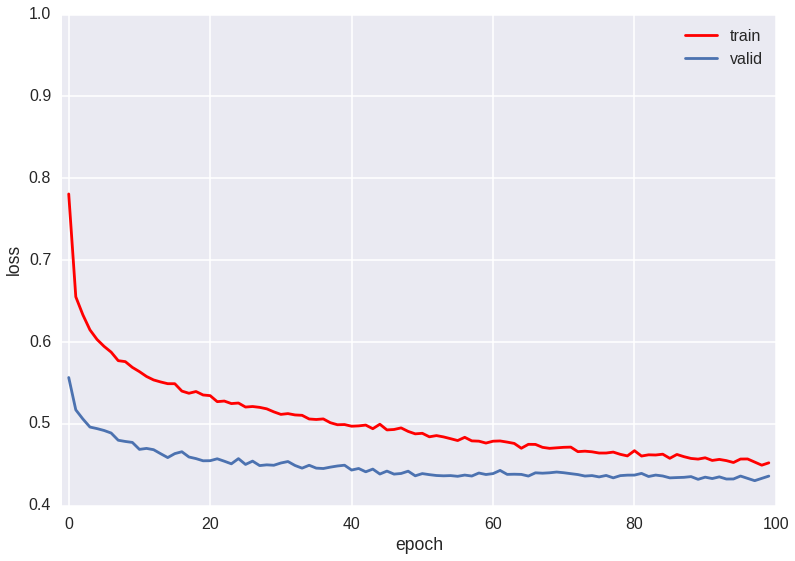

In [14]:
# from sklearn.cross_validation import train_test_split

# X_train, X_valid, y_train, y_valid = train_test_split(train_c, y, train_size=0.95)

np.random.seed(1800) # any random seed to differ bagging
net0.fit(train_coop, y)
plot_training_history(net0)


 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.419219  |    0.433254  |     0.967604  |     84.20%  |  93.9s
     2  |    0.424958  |    0.429297  |     0.989894  |     83.88%  |  97.7s
     3  |    0.421642  |    0.431353  |     0.977489  |     84.51%  |  99.7s
     4  |    0.421649  |    0.433860  |     0.971856  |     84.02%  |  99.8s
     5  |    0.420877  |    0.436198  |     0.964875  |     84.51%  |  100.2s
     6  |    0.423398  |    0.436687  |     0.969569  |     83.57%  |  98.9s
     7  |    0.422578  |    0.433009  |     0.975912  |     83.71%  |  98.8s
     8  |    0.418474  |    0.435496  |     0.960913  |     84.33%  |  98.6s
     9  |    0.418859  |    0.432447  |     0.968577  |     84.51%  |  98.8s
    10  |    0.423322  |    0.434690  |     0.973848  |     83.71%  |  100.0s
    11  |    0.421660  |    0.434653  |     0.970108  |     84.04%  |  99.5

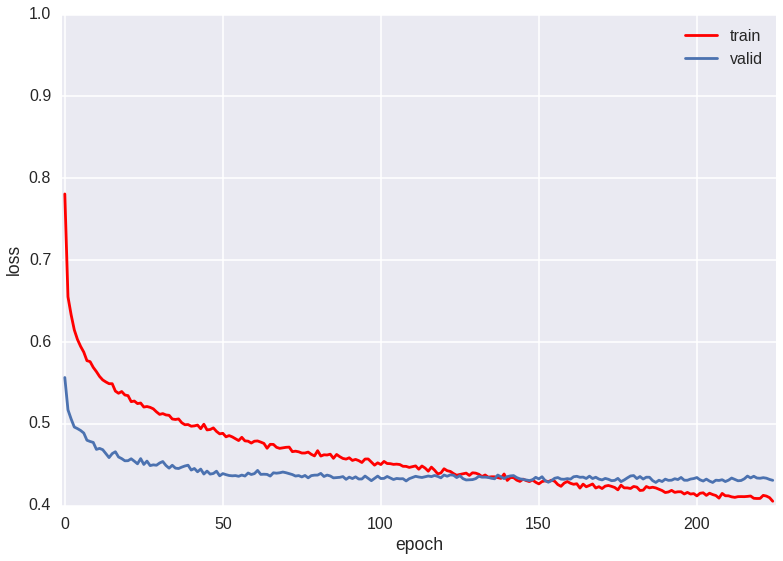

In [18]:
net0.max_epochs = 50
net0.fit(train_coop, y)
plot_training_history(net0)

In [15]:
from sklearn.metrics import confusion_matrix

confused_net = confusion_matrix(y_valid, net0.predict(X_valid))
confused_net

array([[  5,   2,   0,   0,   0,   1,   1,   2,   4],
       [  0, 142,  31,   1,   0,   1,   0,   0,   0],
       [  0,  32,  38,   2,   0,   0,   0,   0,   0],
       [  0,   6,   2,  12,   1,   0,   0,   0,   0],
       [  0,   1,   0,   0,  29,   0,   0,   0,   0],
       [  1,   1,   0,   0,   0, 132,   3,   4,   2],
       [  0,   7,   3,   1,   0,   0,  14,   1,   0],
       [  2,   1,   0,   0,   0,   1,   0,  80,   2],
       [  1,   1,   0,   0,   0,   3,   0,   2,  44]])

In [ ]:
lasagne_confused_weights = [ confused_net[i,i] / np.sum(confused_net[i]) for i in range(confused_net.shape[0]) ]
lasagne_confused_weights

In [20]:
net_imported.predict(train_c)

array([7, 1, 1, ..., 5, 5, 7])

In [59]:
sample = pd.read_csv('data/sampleSubmission.csv')

import time

# make_submission(net0, X_test, ids, encoder)

prob_array = net0.predict_proba(test_c)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('lasagne_drop_5-7-15_150-epochs_lookin-good.csv', index_label='id')
print("done predicting!")

# np.shape(prob_array)

03:56:47
done predicting!


In [13]:
from sklearn.externals import joblib

net_imported = joblib.load('net0_0415.pkl')

  input             	(None, 130)         	produces     130 outputs
  dropoutf          	(None, 130)         	produces     130 outputs
  dense0            	(None, 1000)        	produces    1000 outputs
  dropout           	(None, 1000)        	produces    1000 outputs
  dense1            	(None, 500)         	produces     500 outputs
  dropout2          	(None, 500)         	produces     500 outputs
  output            	(None, 9)           	produces       9 outputs


In [17]:
test_c.shape
train_c.shape

(61878, 130)

In [19]:
train_predicted = net_imported.predict(train_c)
test_predicted = net_imported.predict(test_c)

In [20]:
np.save('train_predicted.npy', train_predicted)
np.save('test_predicted.npy', test_predicted)

In [62]:
from sklearn.externals import joblib
joblib.dump(net0, 'net0_0415.pkl', compress=9)

['net0_0415.pkl', 'net0_0415.pkl_01.npy.z']

In [74]:
sample = pd.read_csv('data/sampleSubmission.csv')

import time

# make_submission(net0, X_test, ids, encoder)

prob_array = net0.predict_proba(test_c)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('lasagne_drop_5-7-15_200-epochs_lookin-good.csv', index_label='id')
print("done predicting!")

# np.shape(prob_array)

14:05:48
done predicting!



 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.452742  |    0.423720  |     1.068494  |     82.43%  |  129.8s
     2  |    0.451395  |    0.423982  |     1.064656  |     83.06%  |  127.8s
     3  |    0.449481  |    0.424945  |     1.057740  |     82.57%  |  126.5s
     4  |    0.449696  |    0.426638  |     1.054047  |     82.59%  |  98.9s
     5  |    0.451388  |    0.423542  |     1.065745  |     82.28%  |  94.9s
     6  |    0.449049  |    0.423178  |     1.061133  |     82.61%  |  98.7s
     7  |    0.449964  |    0.423777  |     1.061793  |     81.94%  |  104.0s
     8  |    0.448171  |    0.422554  |     1.060625  |     82.43%  |  103.2s
     9  |    0.446083  |    0.420120  |     1.061798  |     82.28%  |  107.7s
    10  |    0.450227  |    0.424118  |     1.061561  |     82.46%  |  105.2s
    11  |    0.444407  |    0.424958  |     1.045768  |     81.61%  | 

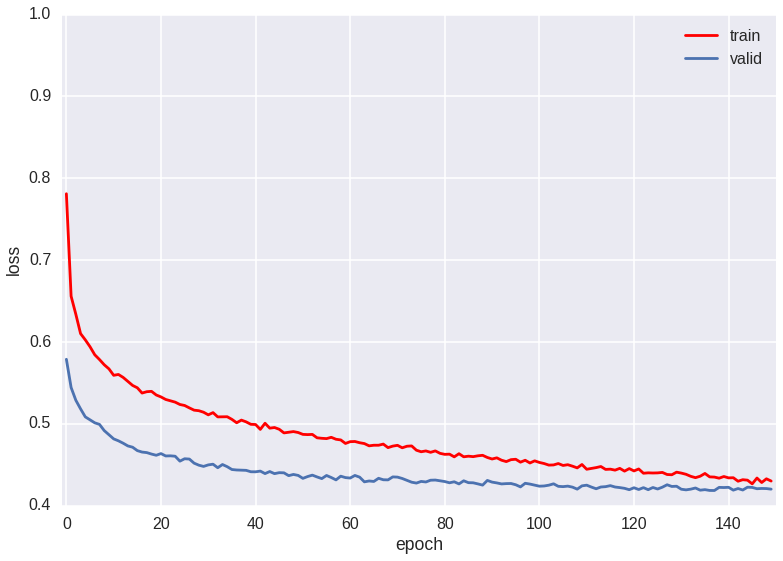

In [27]:
net0.fit(train_c, y)
plot_training_history(net0)


 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.428683  |    0.420379  |     1.019755  |     83.21%  |  90.7s
     2  |    0.431393  |    0.423397  |     1.018886  |     82.72%  |  91.3s
     3  |    0.429919  |    0.423879  |     1.014249  |     82.75%  |  92.3s
     4  |    0.427760  |    0.420176  |     1.018049  |     83.42%  |  92.5s
     5  |    0.428582  |    0.422077  |     1.015411  |     83.26%  |  93.2s
     6  |    0.430301  |    0.425028  |     1.012408  |     82.14%  |  93.5s
     7  |    0.428674  |    0.424484  |     1.009871  |     82.77%  |  93.0s
     8  |    0.426136  |    0.421747  |     1.010406  |     82.92%  |  93.0s
     9  |    0.426400  |    0.421576  |     1.011444  |     83.26%  |  92.6s
    10  |    0.426593  |    0.420464  |     1.014576  |     82.59%  |  92.8s


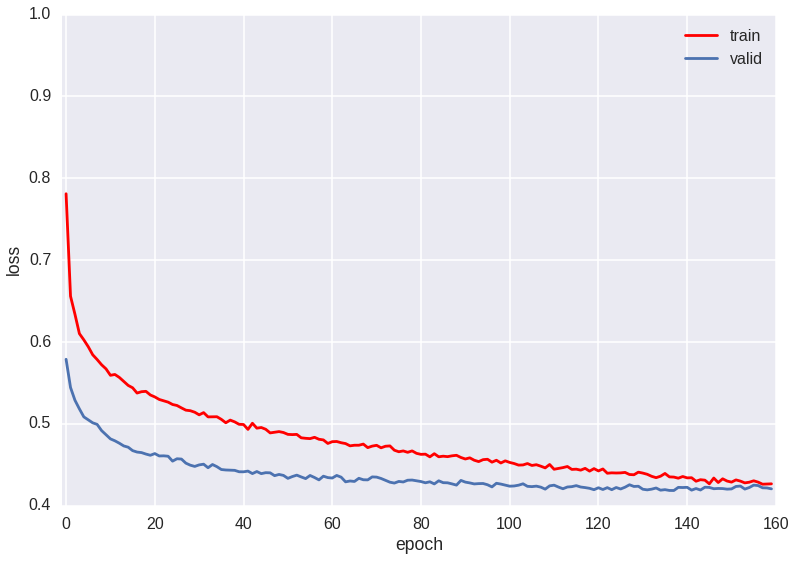

In [29]:
net0.max_epochs = 10
net0.fit(train_c, y)
plot_training_history(net0)


 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.423730  |    0.422697  |     1.002444  |     83.10%  |  89.9s
     2  |    0.426781  |    0.421355  |     1.012877  |     82.81%  |  91.6s
     3  |    0.423477  |    0.420660  |     1.006698  |     82.79%  |  92.5s
     4  |    0.424198  |    0.418596  |     1.013384  |     82.90%  |  93.2s
     5  |    0.427712  |    0.420605  |     1.016899  |     81.94%  |  93.5s
     6  |    0.426145  |    0.420928  |     1.012393  |     82.28%  |  93.2s
     7  |    0.424848  |    0.417280  |     1.018135  |     83.42%  |  93.3s
     8  |    0.423441  |    0.417111  |     1.015177  |     82.28%  |  93.6s
     9  |    0.425063  |    0.416607  |     1.020299  |     82.28%  |  93.7s
    10  |    0.424327  |    0.418492  |     1.013942  |     82.59%  |  93.6s


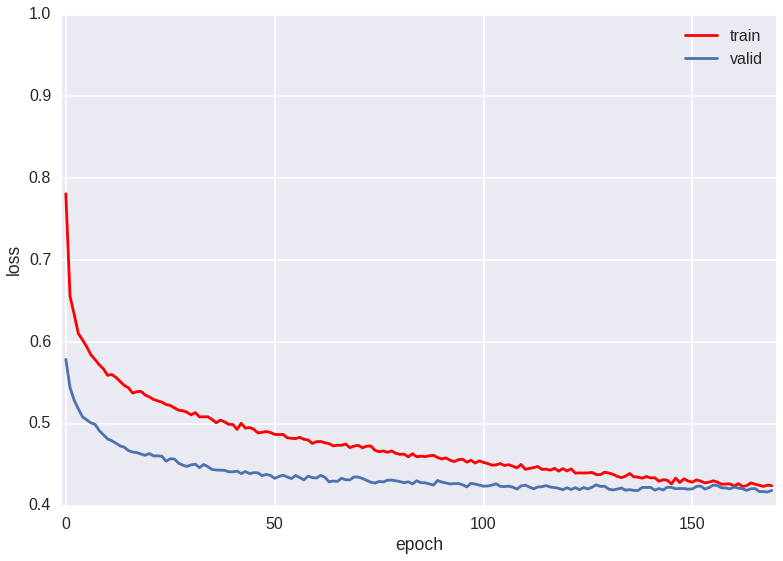

11:47:46
done predicting!


In [31]:
net0.max_epochs = 10
net0.fit(train_c, y)
plot_training_history(net0)

prob_array = net0.predict_proba(test_c)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('lasagne_drop_5-3-15_12pm_170-epochs.csv', index_label='id')
print("done predicting!")


 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.410410  |    0.417124  |     0.983904  |     82.61%  |  94.7s
     2  |    0.410656  |    0.415911  |     0.987366  |     82.77%  |  95.2s
     3  |    0.411412  |    0.415139  |     0.991023  |     83.10%  |  95.3s
     4  |    0.408738  |    0.414988  |     0.984938  |     82.90%  |  95.3s
     5  |    0.410352  |    0.415444  |     0.987744  |     83.75%  |  95.3s
     6  |    0.410367  |    0.415833  |     0.986853  |     82.77%  |  95.7s
     7  |    0.411579  |    0.418703  |     0.982984  |     83.08%  |  96.0s
     8  |    0.412942  |    0.420035  |     0.983114  |     82.90%  |  95.6s
     9  |    0.411253  |    0.418325  |     0.983094  |     82.23%  |  95.2s
    10  |    0.410666  |    0.417906  |     0.982676  |     83.73%  |  95.8s


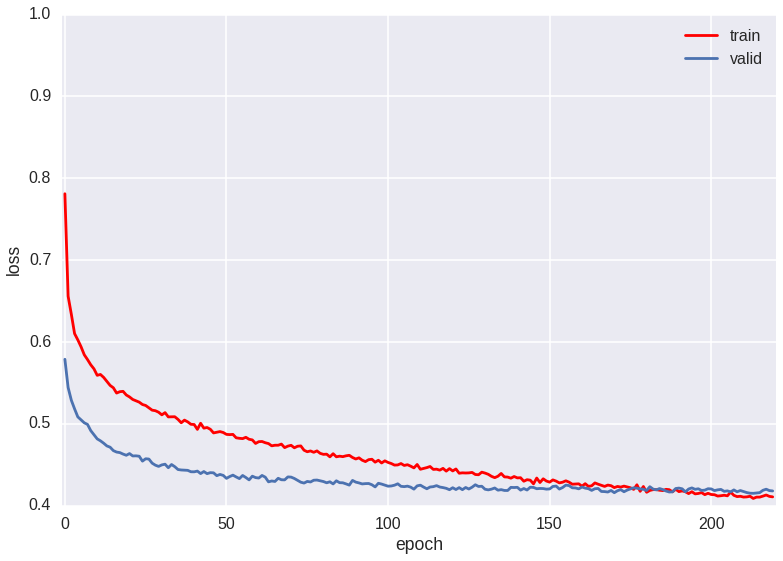

13:45:07
done predicting!


In [37]:
net0.max_epochs = 10
net0.fit(train_c, y)
plot_training_history(net0)

prob_array = net0.predict_proba(test_c)

print(time.ctime().split()[3])

# create submission file
preds = pd.DataFrame(prob_array, index=sample.id.values, columns=sample.columns[1:])
preds.to_csv('lasagne_drop_5-3-15_12pm_220-epochs.csv', index_label='id')
print("done predicting!")